In [488]:
from ahrs.filters import Madgwick
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate as intg
from scipy.integrate import cumtrapz
import time
import math

In [489]:
def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(t3, t4)
    return [yaw, pitch, roll]

def axisAngle2quatern(axis, angle):
    q0 = math.cos(angle/2)
    q1 = -axis[:,0]*math.sin(angle/2)
    q2 = -axis[:,1]*math.sin(angle/2)
    q3 = -axis[:,2]*math.sin(angle/2) 
    q = [q0, q1, q2, q3]
    return q 

def axisAngle2rotMat(axis, angle):
    R = []
    kx = axis[:,0]
    ky = axis[:,1]
    kz = axis[:,2]
    cT = math.cos(angle)
    sT = math.sin(angle)
    vT = 1 - math.cos(angle)
    
    R[0,0,:] = kx*kx*vT + cT
    R[0,1,:] = kx*ky*vT - kz*sT
    R[0,2,:] = kx*kz*vT + ky*sT
    
    R[1,0,:] = kx*ky*vT + kz*sT
    R[1,1,:] = ky*ky*vT + cT
    R[1,2,:] = ky*kz*vT - kx*sT
    
    R[2,0,:] = kx*kz*vT - ky*sT
    R[2,1,:] = ky*kz*vT + kx*sT
    R[2,2,:] = kz*kz*vT + cT
    
    return R

def quaternionProduct(a, b):
    ab = np.zeros([len(a),len(a[0])])
    a = np.array(a)
    b = np.array(b)
    #print(b)
    ab[0] = a[0]*b[0]-a[1]*b[1]-a[2]*b[2]-a[3]*b[3]
    ab[1] = a[0]*b[1]+a[1]*b[0]+a[2]*b[3]-a[3]*b[2]
    ab[2] = a[0]*b[2]-a[1]*b[3]+a[2]*b[0]+a[3]*b[1]
    ab[3] = a[0]*b[3]+a[1]*b[2]-a[2]*b[1]+a[3]*b[0]
    #print(len(ab[0,:]))
    #print('quaternProd ran', ab, type(ab), len(ab), len(ab[0]))
    #print(ab)
    return ab

def quaternionRotate(v, q):
    size = np.shape(v)

    col = size[0]
    row = size[1]

    v = [list((np.zeros(row))),v[0],v[1],v[2]]
    #print(v)
    v = np.array(v)
    v0XYZ = quaternionProduct(quaternionProduct(q, v), quaternionConjugate(q))
    #print('v0XYZ ran', v0XYZ, type(v0XYZ), len(v0XYZ), len(v0XYZ[0]))
    v = [v0XYZ[1], v0XYZ[2], v0XYZ[3]]
    
    return v

def quaternionConjugate(q):
    if len(q)==4:
        q = np.transpose(q)
    #print(q)
    # print(q, len(q), len(q[0]))
    qConj = np.array([q[:,0], -q[:,1], -q[:,2], -q[:,3]])
    #print('quaternConj ran', qConj, type(qConj), len(qConj), len(qConj[0]))
    return qConj


In [490]:
with open("IMU.csv", "r") as i:
    rawdata = list(csv.reader(i,delimiter=","))
exampledata = np.array(rawdata[0:],dtype=float)

acc_data = exampledata[:,1:4]
gyro_data = exampledata[:,4:7]
mag_data = exampledata[:,7:10]
q_data = exampledata[:,10:14]

num_samples = len(acc_data)
madgwick = Madgwick()

Q = np.tile([0., 0., 0., 0.], (num_samples, 1)) # Allocate for quaternions
E = np.tile([0., 0., 0.], (num_samples, 1)) # Allocate for eulers
for t in range(0, num_samples):
    Q[t] = madgwick.updateMARG(Q[t-1], gyr=gyro_data[t], acc=acc_data[t], mag=mag_data[t])
    E[t] = quaternion_to_euler(Q[t][0],Q[t][1],Q[t][2],Q[t][3])

In [491]:
accX = acc_data[:,0]
accY = acc_data[:,1]
accZ = acc_data[:,2]
quat = q_data
acc = quaternionRotate([accX, accY, accZ], quaternionConjugate(quat))
acc = np.array(acc) - np.array([np.zeros(num_samples), np.zeros(num_samples), np.ones(num_samples)])
acc = acc*9.81

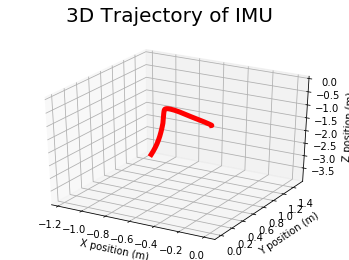

In [492]:
xdata = acc[0]
ydata = acc[1]
zdata = acc[2]

dt = 0.0025 #time between samples THIS SHOULD BE 1/sampling frequency from the ARDUINO (1/40Hz)
x =cumtrapz(cumtrapz(xdata,dx=dt),dx=dt)
y =cumtrapz(cumtrapz(ydata,dx=dt),dx=dt)
z =cumtrapz(cumtrapz(zdata,dx=dt),dx=dt)
# Plot 3D Trajectory
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of IMU',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
plt.show()